In [1]:
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import rgrow
import alhambra
import numpy as np
from alhambra.grid import AbstractLattice
import polars as pl
import re
import seaborn as sns

In [2]:
PREFIX = 'aflag'

In [3]:
ts = alhambra.TileSet.from_file("evans2024-pattern-recognition-alhambra.json")

In [4]:
ts.params['concentration'] = 50 # in nM, base concentration for tiles.
ts.params['alpha'] = -7.1 # alpha parameter for kTAM; this is what we use in SHAM
# ts.params['glue-handling'] = 'orthogonal' # don't model interactions between non-WC pairs
ts.params['glue-handling'] = 'full'
ts.params['fission'] = 'keep-weighted' # when structures split, randomly keep one, weighting by size
ts.params['model'] = 'KTAM' # use the kTAM
ts.params['chunk-handling'] = 'detach' # allow dimers to detach from the structure
ts.params['chunk-size'] = 'dimer'
ts.params['temperature'] = 48.5


In [5]:
for tn in [111, 105, 159, 417, 228, 211, 193, 182, 180, 654, 425, 84]:
    ts.tiles[tn].stoic = 10.0
    ts.tiles[tn].color = 'black'

In [6]:
rts = ts.to_rgrow()
rts.size = (16, 16)
rts.canvas_type = "Periodic"
res = rts.run_ffs(
    min_nuc_rate=1e-15,
    var_per_mean2=1e-5,
    min_cutoff_size=60,
    min_configs=5000,
    max_configs=5000,
    target_size=150,
    keep_configs=True,
)
sys = rts.create_system()

In [7]:
nr = res.nucleation_rate

In [8]:
nr

7.16792097087657e-12

In [9]:
sd = res.surfaces_dataframe()
sd


level,n_configs,n_trials,target_size,p_r
u64,u64,u64,u64,f64
0,5000,5000,2,1.0
1,5000,61689,3,0.081052
2,5000,33890,4,0.147536
3,5000,27715,5,0.180408
4,5000,22334,6,0.223874
…,…,…,…,…
108,5000,5046,110,0.990884
109,5000,5049,111,0.990295
110,5000,5040,112,0.992063


In [10]:
plt.style.use('default.mplstyle')


In [11]:
cd = res.configs_dataframe()
cd

surface_index,config_index,size,time,previous_config,canvas,min_i,min_j,max_i,max_j,shape_i,shape_j
u64,u64,u32,f64,u64,list[u32],u64,u64,u64,u64,u64,u64
0,0,2,0.0,643,"[229, 643]",8,8,9,8,2,1
0,1,2,0.0,530,"[530, 70]",8,8,9,8,2,1
0,2,2,0.0,798,"[798, 804]",8,8,9,8,2,1
0,3,2,0.0,831,"[160, 831]",8,8,9,8,2,1
0,4,2,0.0,575,"[575, 454]",8,8,9,8,2,1
…,…,…,…,…,…,…,…,…,…,…,…
112,4995,114,2679.936553,1348,"[0, 0, … 0]",1,0,14,15,14,16
112,4996,114,5508.81212,322,"[0, 0, … 384]",1,0,12,15,12,16
112,4997,114,4698.908977,4655,"[876, 0, … 356]",3,0,15,15,13,16


In [12]:
del(res)

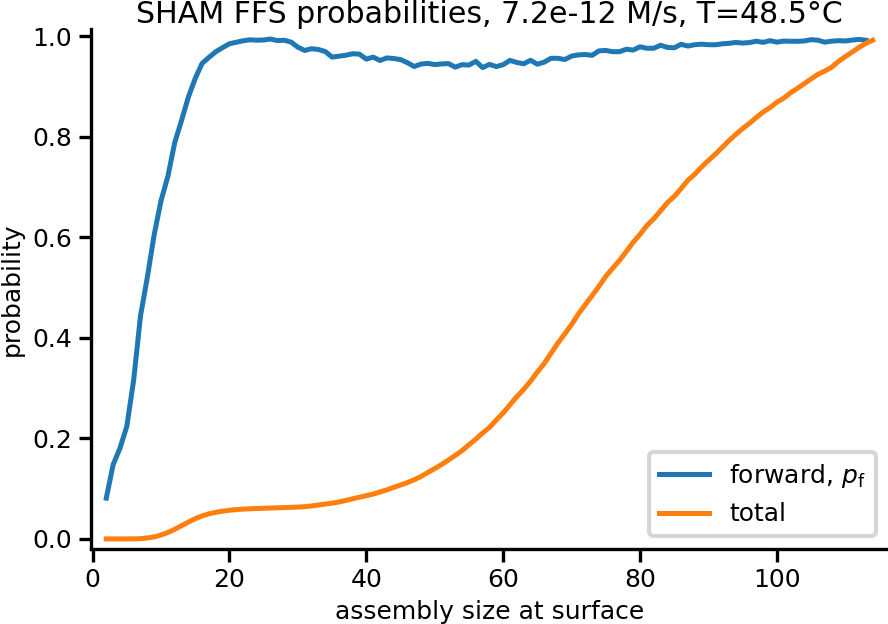

In [13]:
fig, ax = plt.subplots(figsize=(3, 2.12))
ax.plot(
    sd.get_column('target_size'),
    sd.get_column('p_r').shift(-1),
    label='forward, $p_\\text{f}$'
)
ax.plot(
    sd.get_column('target_size'),
    sd.get_column('p_r').to_numpy()[::-1].cumprod()[::-1],
    label='total'
)
ax.set_xlabel('assembly size at surface')
ax.set_ylabel('probability')
ax.set_title(f"SHAM FFS probabilities, {nr:2.1e} M/s, T=48.5°C")
ax.legend()
fig.savefig(f'{PREFIX}-sham-assembly-size-vs-probabilities.pdf')

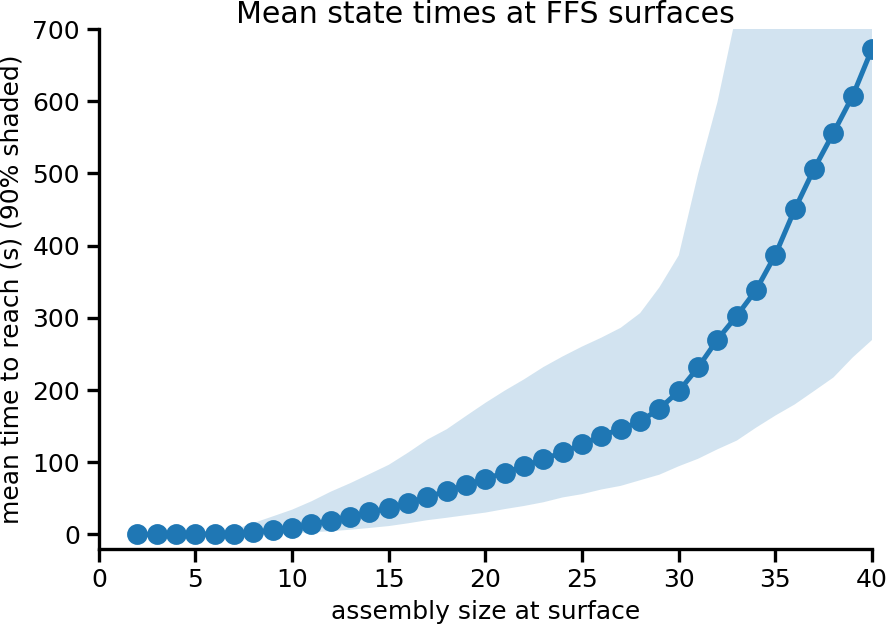

In [14]:
q = cd.group_by("size", maintain_order=True).agg(
    pl.col("time").quantile(0.5).alias("time_median"),
    pl.col("time").quantile(0.95).alias("time_95"),
    pl.col("time").quantile(0.05).alias("time_05"),
)
fig, ax = plt.subplots(figsize=(3, 2.12))#constrained_layout=True)
ax.plot(q["size"], q["time_median"], "o-")
ax.fill_between(q["size"], q["time_05"], q["time_95"], alpha=0.2)
ax.set_xlabel("assembly size at surface")
ax.set_ylabel("mean time to reach (s) (90% shaded)")
ax.set_xlim(0, 40)
ax.set_ylim(-20, 700)
ax.set_title("Mean state times at FFS surfaces")
fig.savefig(f'{PREFIX}-sham-mean-state-times.pdf')

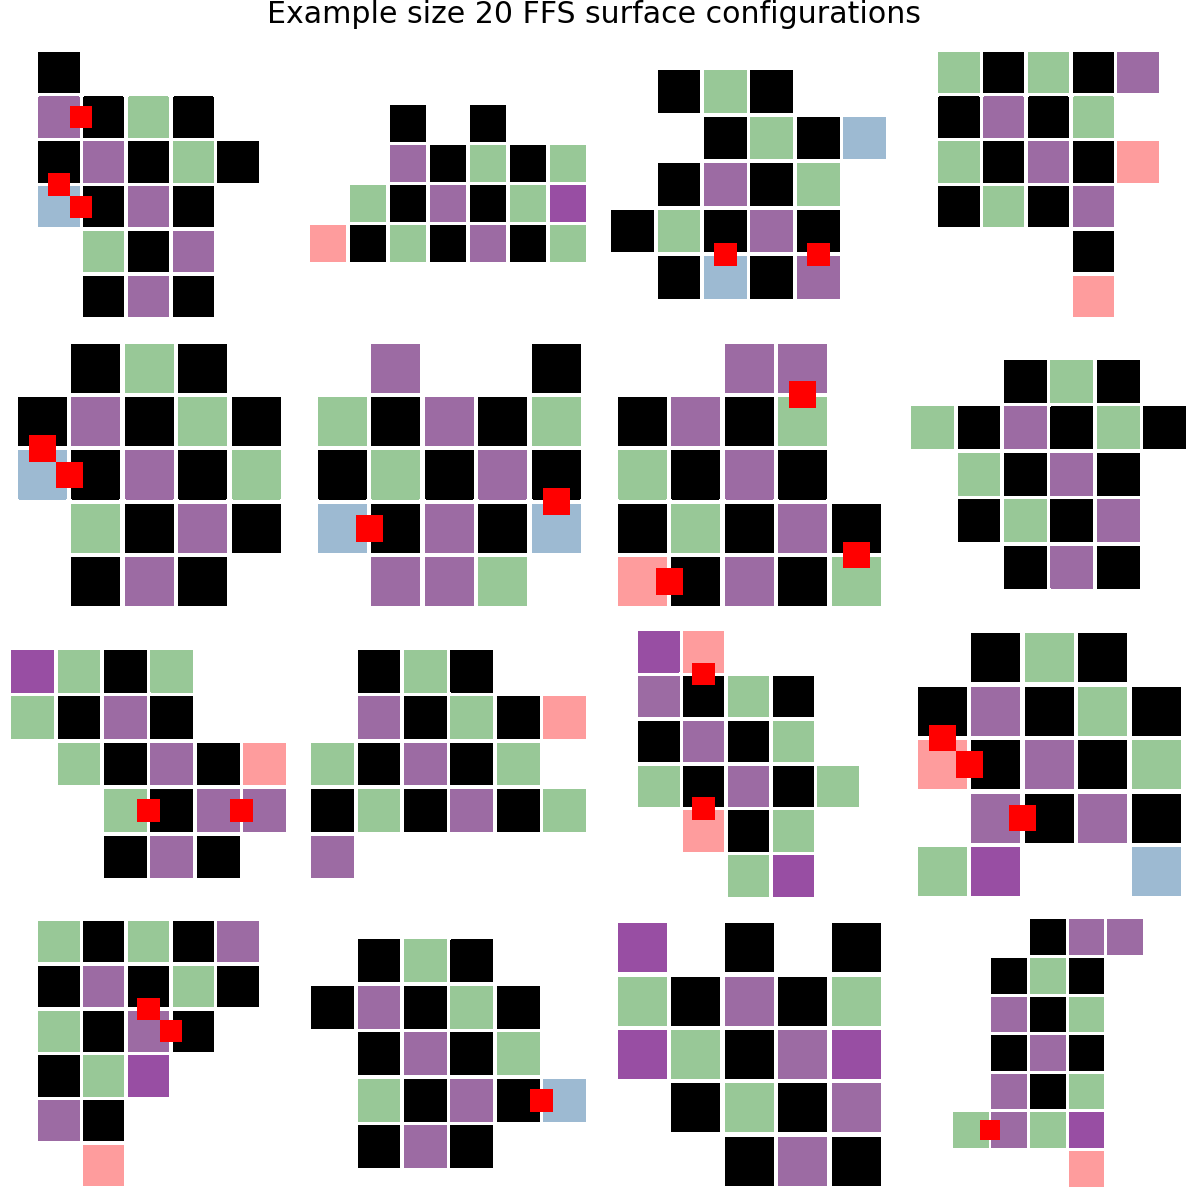

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))

cf = cd.filter(pl.col("size") == 20)

for i, ax in enumerate(axs.flat):
    canvas = cf[i, "canvas"].to_numpy().reshape(cf[i, "shape_i"], cf[i, "shape_j"])
    v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
    v[1:-1, 1:-1] = canvas
    state = rts._to_rg_tileset().create_state_from_canvas(v)
    ax = sys.plot_canvas(state, annotate_mismatches=True, ax=ax)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]+1, xl[1]-1)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0]-1, yl[1]+1)
    ax.set_axis_off()
    #ax.set_title(f"size {cd[g+i, 'size']}; time {cd[g+i, 'time']} s")

fig.suptitle("Example size 20 FFS surface configurations")
fig.savefig(f'{PREFIX}-sham-example-ffs-surface-assemblies.pdf')

# canvas = cd[g, "canvas"].to_numpy().reshape(cd[g, "shape_i"], cd[g, "shape_j"])
# v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
# v[1:-1, 1:-1] = canvas
# state = rts._to_rg_tileset().create_state_from_canvas(v)
# ax = sys.plot_canvas(state, annotate_tiles=True, annotate_mismatches=True, ax=ax)
# ax.set_axis_off()
# # ax.set_ylim( 5.5, 0.5)
# # ax.set_xlim(0.5, 7.5)
# ax.set_title("SHAM example state: size 19; time 207 s")
# # ax.get_figure().savefig('sham-example-state.pdf')

In [16]:
# g = 85100
# canvas = cd[g, "canvas"].to_numpy().reshape(cd[g, "shape_i"], cd[g, "shape_j"])
# v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
# v[1:-1, 1:-1] = canvas
# state = rts._to_rg_tileset().create_state_from_canvas(v)
# fig, ax = plt.subplots(figsize=(3, 3))
# ax = sys.plot_canvas(state, annotate_tiles=True, annotate_mismatches=True, ax=ax)
# ax.set_axis_off()
# # ax.set_ylim( 5.5, 0.5)
# # ax.set_xlim(0.5, 7.5)
# ax.set_title("SHAM example state: size 19; time 207 s")
# # ax.get_figure().savefig('sham-example-state.pdf')

In [17]:
recs = []
c = cd[-1]
while not c.is_empty():
    recs.append(c)
    c = cd.filter((pl.col("surface_index") == c['surface_index'][0]-1) & (pl.col("config_index") == c['previous_config'][0]))
traj = pl.concat(recs[::-1])

In [18]:
traj

surface_index,config_index,size,time,previous_config,canvas,min_i,min_j,max_i,max_j,shape_i,shape_j
u64,u64,u32,f64,u64,list[u32],u64,u64,u64,u64,u64,u64
0,1575,2,0.0,47,"[112, 47]",8,8,9,8,2,1
1,1575,3,0.320353,1575,"[0, 112, … 47]",8,7,9,8,2,2
2,4285,4,0.40919,1575,"[0, 112, … 0]",8,7,10,8,3,2
3,3364,5,0.418051,4285,"[0, 0, … 0]",8,6,10,8,3,3
4,3803,6,0.46838,3364,"[0, 112, … 0]",8,7,10,9,3,3
…,…,…,…,…,…,…,…,…,…,…,…
108,4494,110,3070.933612,806,"[0, 0, … 690]",5,0,14,15,10,16
109,1174,111,3072.507583,4494,"[0, 0, … 0]",0,0,15,15,16,16
110,4172,112,3072.52096,1174,"[0, 0, … 0]",0,0,15,15,16,16


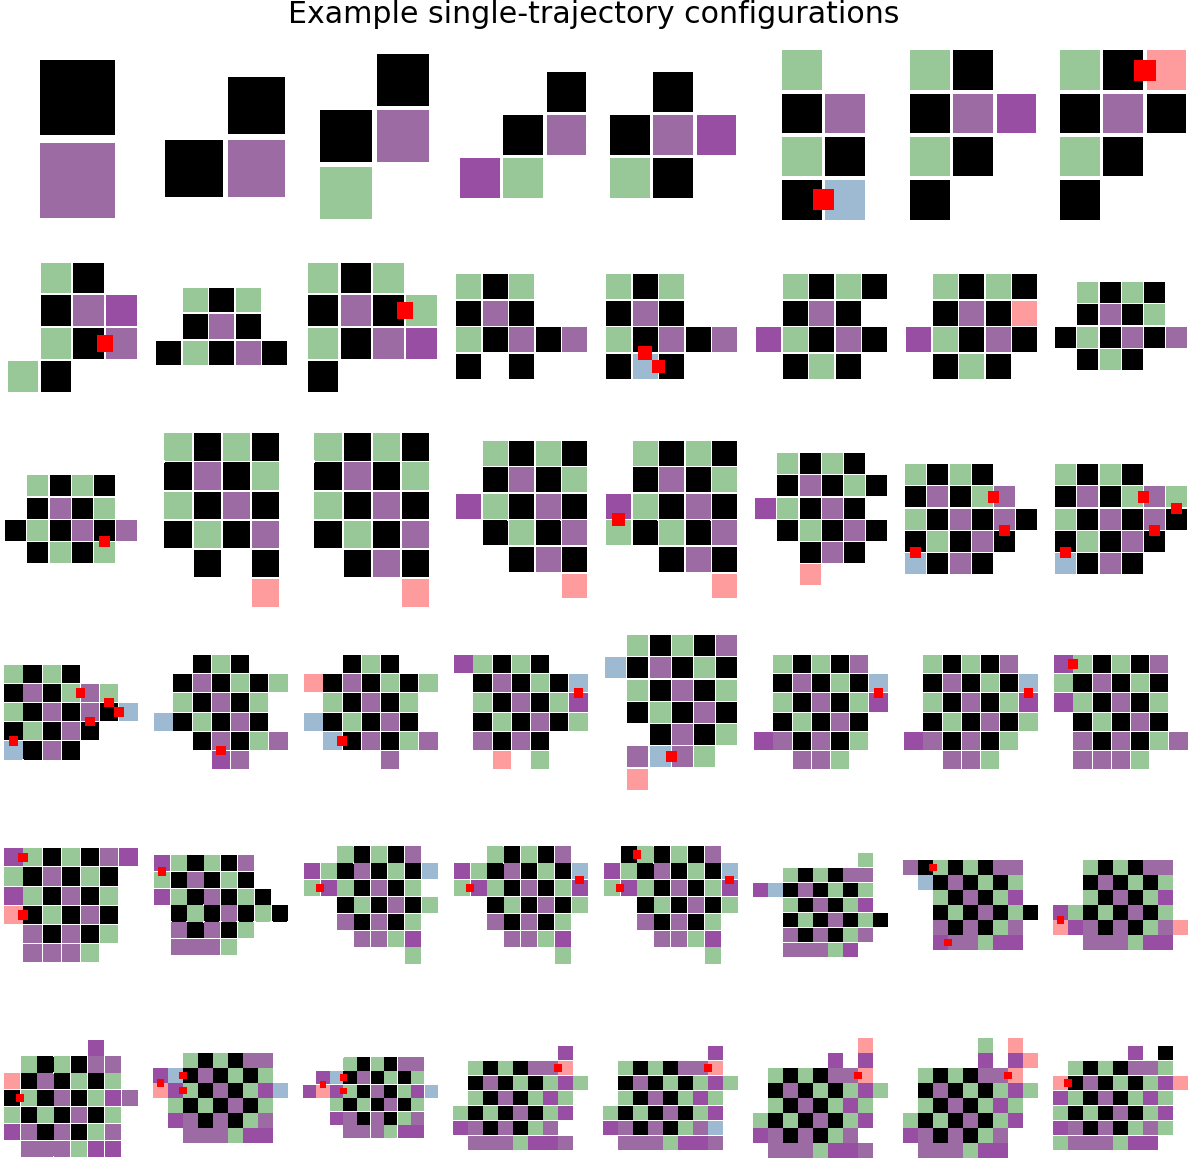

In [19]:
fig, axs = plt.subplots(6, 8, figsize=(4, 4))


for z, ax in zip(traj.iter_rows(named=True), axs.flat):
    canvas = np.array(z["canvas"], dtype=np.uint32).reshape(z["shape_i"], z["shape_j"])
    v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
    v[1:-1, 1:-1] = canvas
    state = rts._to_rg_tileset().create_state_from_canvas(v)
    ax = sys.plot_canvas(state, annotate_mismatches=True, ax=ax)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]+1, xl[1]-1)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0]-1, yl[1]+1)
    ax.set_axis_off()
    #ax.set_title(f"size {cd[g+i, 'size']}; time {cd[g+i, 'time']} s")

fig.suptitle("Example single-trajectory configurations")
fig.savefig(f'{PREFIX}-sham-example-trajectory.pdf')

# canvas = cd[g, "canvas"].to_numpy().reshape(cd[g, "shape_i"], cd[g, "shape_j"])
# v = np.zeros((canvas.shape[0]+2, canvas.shape[1]+2), dtype=np.uint32)
# v[1:-1, 1:-1] = canvas
# state = rts._to_rg_tileset().create_state_from_canvas(v)
# ax = sys.plot_canvas(state, annotate_tiles=True, annotate_mismatches=True, ax=ax)
# ax.set_axis_off()
# # ax.set_ylim( 5.5, 0.5)
# # ax.set_xlim(0.5, 7.5)
# ax.set_title("SHAM example state: size 19; time 207 s")
# # ax.get_figure().savefig('sham-example-state.pdf')

In [20]:
uh = np.array([re.match('[H]', x) is not None for x in sys.tile_names])
ua = np.array([re.match('[A]', x) is not None for x in sys.tile_names])
um = np.array([re.match('[M]', x) is not None for x in sys.tile_names])

In [21]:
cd

surface_index,config_index,size,time,previous_config,canvas,min_i,min_j,max_i,max_j,shape_i,shape_j
u64,u64,u32,f64,u64,list[u32],u64,u64,u64,u64,u64,u64
0,0,2,0.0,643,"[229, 643]",8,8,9,8,2,1
0,1,2,0.0,530,"[530, 70]",8,8,9,8,2,1
0,2,2,0.0,798,"[798, 804]",8,8,9,8,2,1
0,3,2,0.0,831,"[160, 831]",8,8,9,8,2,1
0,4,2,0.0,575,"[575, 454]",8,8,9,8,2,1
…,…,…,…,…,…,…,…,…,…,…,…
112,4995,114,2679.936553,1348,"[0, 0, … 0]",1,0,14,15,14,16
112,4996,114,5508.81212,322,"[0, 0, … 384]",1,0,12,15,12,16
112,4997,114,4698.908977,4655,"[876, 0, … 356]",3,0,15,15,13,16


In [22]:
cd = cd.with_columns(
    n_h=pl.col("canvas").map_elements(lambda x: uh[x].sum()),
    n_a=pl.col("canvas").map_elements(lambda x: ua[x].sum()),
    n_m=pl.col("canvas").map_elements(lambda x: um[x].sum()),
).with_columns(
    p_h=pl.col("n_h") / pl.col("size"),
    p_a=pl.col("n_a") / pl.col("size"),
    p_m=pl.col("n_m") / pl.col("size"),
)
mm = cd.group_by("size", maintain_order=True).agg(
    h = (pl.col("p_h") > 0.2).mean(),
    a = (pl.col("p_a") > 0.2).mean(),
    m = (pl.col("p_m") > 0.2).mean()
)

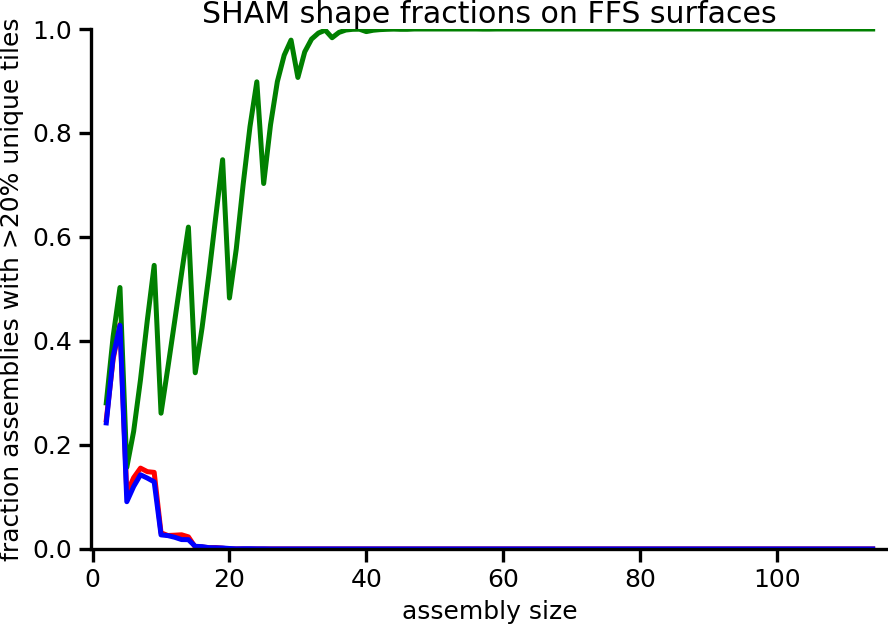

In [23]:
fig, ax = plt.subplots(figsize=(3, 2.12))
ax.plot(mm['size'], mm['h'], color='red')
ax.plot(mm['size'], mm['a'], color='green')
ax.plot(mm['size'], mm['m'], color='blue')
ax.set_ylim(0, 1)
ax.set_ylabel("fraction assemblies with >20% unique tiles")
ax.set_xlabel("assembly size")
ax.set_title("SHAM shape fractions on FFS surfaces")
fig.savefig(f'{PREFIX}-sham-unique-tiles.pdf')

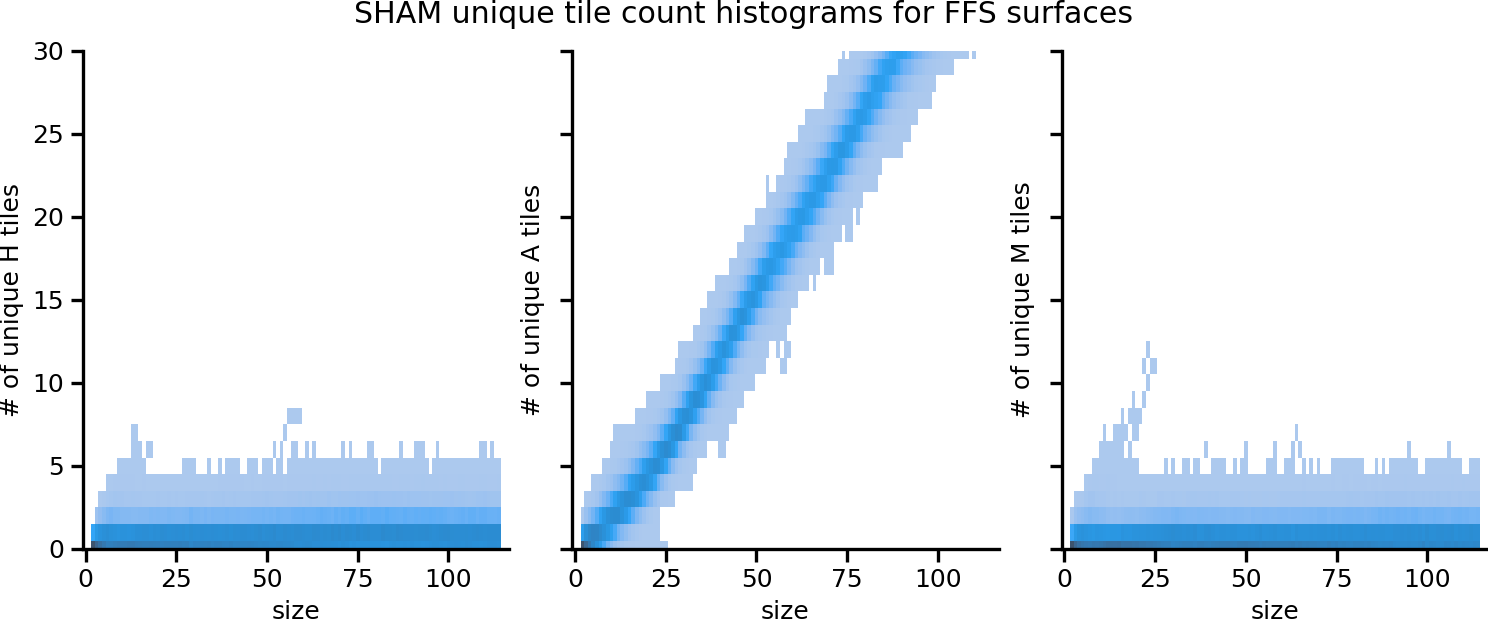

In [24]:
s = "a"
fig, axs = plt.subplots(1, 3, figsize=(5, 2.12))

for s, ax in zip(['h', 'a', 'm'], axs):
    sns.histplot(x=cd['size'], y=cd[f'n_{s}'], discrete=True, ax=ax)# , bins=50) # , height=2)
    ax.set_ylabel(f"# of unique {s.upper()} tiles")
    if s != 'h':
        ax.set_yticklabels([])
    ax.set_ylim(0, 30)

fig.suptitle("SHAM unique tile count histograms for FFS surfaces")
fig.savefig(f'{PREFIX}-sham-unique-tile-histograms.pdf')
#sns.histplot(x=cd['size'], y=cd['n_h'], discrete=True)# , bins=50) # , height=2)
#sns.histplot(x=cd['size'], y=cd['n_m'], discrete=True)# , bins=50) # , height=2)